# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606596 sha256=a75bfaf546cb8d8e75b5b470ff604de26364ccb63d1e3eeedfdf741c46dcaba3
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items, top_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = top_items(data_train_lvl_1, top_num=5000, fictive=-9) # top 5000 товаров

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


C:\DS_Soft\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [5]:
recommender.get_recommendation(2375, N=5)

[899624, 923746, 1037863, 845208, 844179]

In [6]:
recommender.get_recommendation(2375, N=5, similar_users=True)

[1036501, 1079023, 1085983, 907099, 910439]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[868764, 889731, 981760, 1046545, 9527160]

In [ ]:
# recommender.get_similar_users_recommendation(2375, N=5)

[1101502, 979674, 10457044, 974265, 959455]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[1082212, 5570882, 822677, 888650, 992622]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [5]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [ ]:
# your_code

In [8]:
result_lvl_1.drop(1715, inplace=True)

In [31]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_recommendation(x, N=50))
score = {}
score['als_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual'], k=50), axis=1).mean()

result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_recommendation(x, N=50, similar_users=True))
score['own_rec_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_rec'], row['actual'], k=50), axis=1).mean()

result_lvl_1['sim_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
score['sim_items_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['sim_items'], row['actual'], k=50), axis=1).mean()

# result_lvl_1['sim_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))
# score['sim_users_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['sim_users'], row['actual'], k=50), axis=1).mean()

In [32]:
score

{'als_recall': 0.07839152027059064,
 'own_rec_recall': 0.10383473108361768,
 'sim_items_recall': 0.06366643371816745}

Да, действительно, у own recommendtions + top-popular лучший recall.

In [28]:
recall_k = []
result_lvl_1['own_500'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_recommendation(x, N=500, similar_users=True))
for k in [20, 50, 100, 200, 500]:
    recall_k.append(result_lvl_1.apply(lambda row: recall_at_k(row['own_500'], row['actual'], k=k), axis=1).mean())

In [27]:
recall_k

[0.06442443346048478,
 0.10383473108361768,
 0.15323105771763387,
 0.23012301154335943,
 0.3424887249818663]

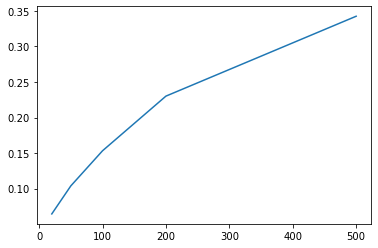

In [30]:
plt.plot([20, 50, 100, 200, 500], recall_k)
plt.show()

Полнота, растёт с k, что логично, так как чем больше мы порекомендуем товаров к покупке, тем больше шансов, что мы угадаем, что покупателю интересно. Однако, не можем же мы порекомендовать 500 товаров! Хотя и стоня выглядит не очень разумным числом.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
# your_code

# Задание 3


X_val подготовить из data_val_lvl_2 также как и X_train из targets_lvl_2
val_preds = lgb.predict(X_val) #, где X_val - датасет подготовленный по аналогии с data_train_lvl_2

Далее оценить на валидационном множестве precision

Сравнить с трейном (у меня было 0.78782)

In [ ]:
# your_code

In [ ]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    try:
        recommended_list = recommended_list[:k]
    except:
        recommended_list = []
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [ ]:
train_data_result = X_train[X_train['y_true']>0].groupby('user_id')['item_id'].agg(list).reset_index()
preds = X_train[X_train['preds']>0].groupby('user_id')['item_id'].agg(list).reset_index()
train_data_result.rename(columns={'item_id':'actual'}, inplace = True)
train_data_result = train_data_result.merge(preds, how='left', on='user_id')
train_data_result.rename(columns={'item_id':'lightGBM'}, inplace = True)

In [ ]:
train_data_result.apply(lambda row: precision_at_k(row['lightGBM'], row['actual']), axis=1).mean()

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 